In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

In [3]:
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = DigitCNN().to(device)

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_acc = []

In [5]:
epochs = 5

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    avg_loss = total_loss / len(train_loader)

    train_acc.append(acc)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={acc:.2f}%")

Epoch 1: Loss=0.2016, Accuracy=93.92%
Epoch 2: Loss=0.0590, Accuracy=98.18%
Epoch 3: Loss=0.0409, Accuracy=98.77%
Epoch 4: Loss=0.0314, Accuracy=99.05%
Epoch 5: Loss=0.0248, Accuracy=99.21%


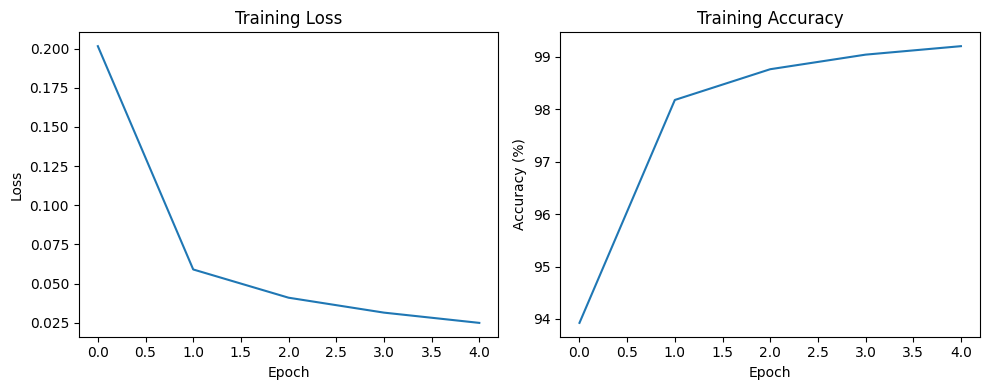

In [6]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_acc)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()

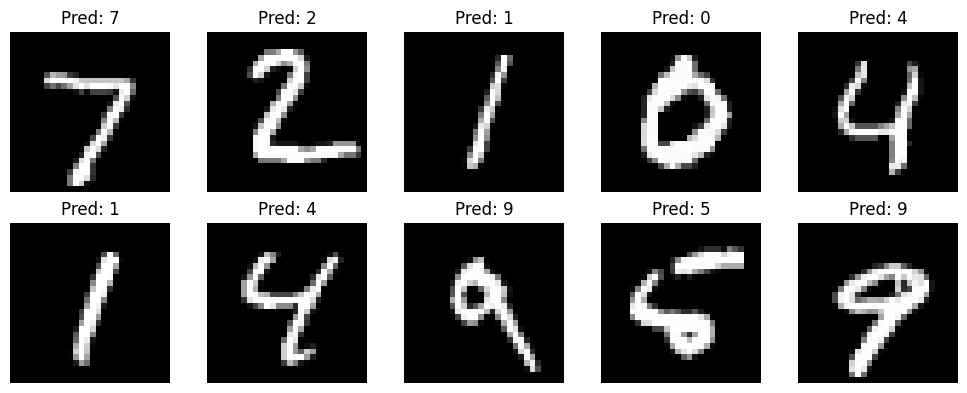

In [7]:
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

plt.figure(figsize=(10,4))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.title(f"Pred: {preds[i].item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

Final Test Accuracy: 98.91%
